1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from pandas import Series, DataFrame

df=pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
del df['Unnamed: 0']
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [142]:
df['default']=df['default'].replace("Yes",1)
df['default']=df['default'].replace("No",0)
df['student']=df['student'].replace("Yes",1)
df['student']=df['student'].replace("No",0)
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

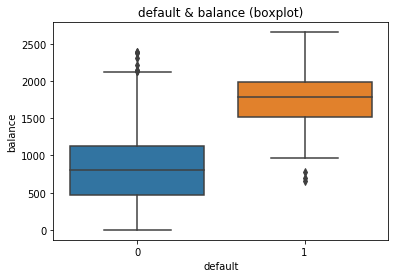

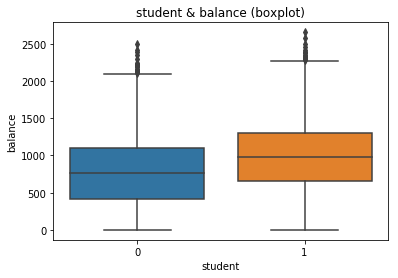

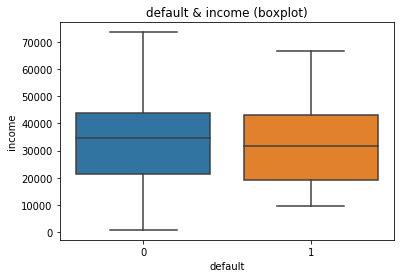

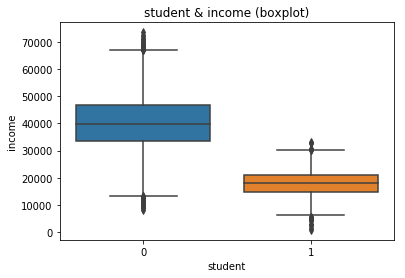

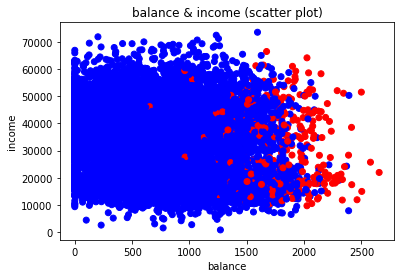

In [143]:
#boxplots
ax=sns.boxplot(x=df["default"],y=df["balance"],data=df)
plt.title("default & balance (boxplot)")
plt.show()
ax=sns.boxplot(x=df["student"],y=df["balance"],data=df)
plt.title("student & balance (boxplot)")
plt.show()
ax=sns.boxplot(x=df["default"],y=df["income"],data=df)
plt.title("default & income (boxplot)")
plt.show()
ax=sns.boxplot(x=df["student"],y=df["income"],data=df)
plt.title("student & income (boxplot)")
plt.show()

#scatter plot
colors= {1:"red",0:"blue"}
plt.scatter(df["balance"],df["income"],c = df["default"].apply(lambda x:colors[x]))
plt.xlabel("balance")
plt.ylabel("income")
plt.title("balance & income (scatter plot)")
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

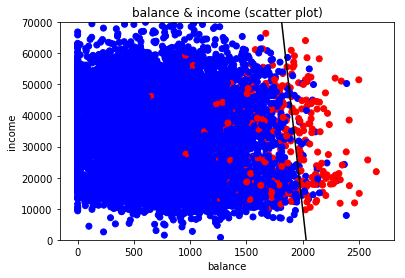

Area under the ROC curve : 0.950896


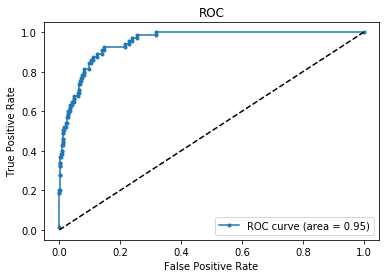

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logregr

X=df[['balance','income']]
y=df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
reg=logregr(penalty='l1')
mod=reg.fit(X_train,y_train)

coef=mod.coef_[0]
b=mod.intercept_
range_=np.arange(0, 2600, 1)
bdry=(b+coef[0]*range_)/-coef[1]

plt.plot(range_,bdry, color='black')

plt.ylim(0, 70000)
colors={1:"red",0:"blue"}
plt.scatter(df["balance"],df["income"],c = df["default"].apply(lambda x:colors[x]))
plt.xlabel("balance")
plt.ylabel("income")
plt.title("balance & income (scatter plot)")

plt.show()


from sklearn.metrics import auc, roc_curve
#Y_predict = reg.predict(X_test)
Y_score = mod.decision_function(X_test)
fpr,tpr,_ = roc_curve(y_test,Y_score)
area = auc(fpr,tpr)

def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,logregr,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()
    
generate_ROCplot(fpr,tpr,'LR',area)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

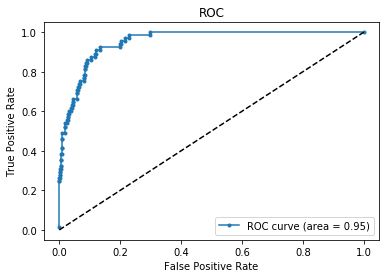

Area under the ROC curve : 0.953099


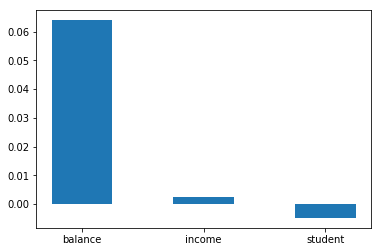

coefficient: [ 0.06397038  0.00240192 -0.00480048]


In [145]:
from sklearn.linear_model import Ridge
X=df[['balance','income','student']]
y=df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
reg=logregr(penalty='l1')
mod=reg.fit(X_train,y_train)

#Y_predict = reg.predict(X_test)
Y_score = mod.decision_function(X_test)
fpr,tpr,_ = roc_curve(y_test,Y_score)
area = auc(fpr,tpr)
generate_ROCplot(fpr,tpr,'LR',area)
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,logregr,C=0.1,penalty='l1')

alphas = np.logspace(-6,-1,100)
test_score=[]

for alpha in alphas:
    
    regr = Ridge(alpha=alpha)
    regr.fit(X_train, y_train)
    test_score.append(regr.score(X_test, y_test))
    
index = np.array(test_score).argmax()

regr = Ridge(alpha = alphas[index])
regr.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), regr.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches
plt.show()
print ('coefficient:',regr.coef_)

**It seems like the performance is not improved significantly with the added variables.**

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

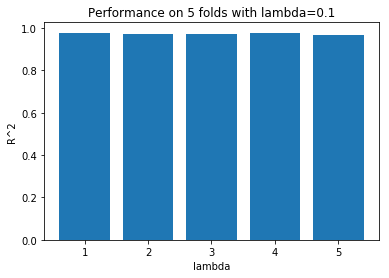

[ 0.97751405  0.97189257  0.973125    0.97435897  0.96873046]


In [146]:
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(reg, X_train, y_train, cv=5)
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.title('Performance on 5 folds with lambda=' + str(alpha))
plt.bar(range(1,6),scores1)
plt.show()
print(scores1)

**The model seems robust with large R2 value.**

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

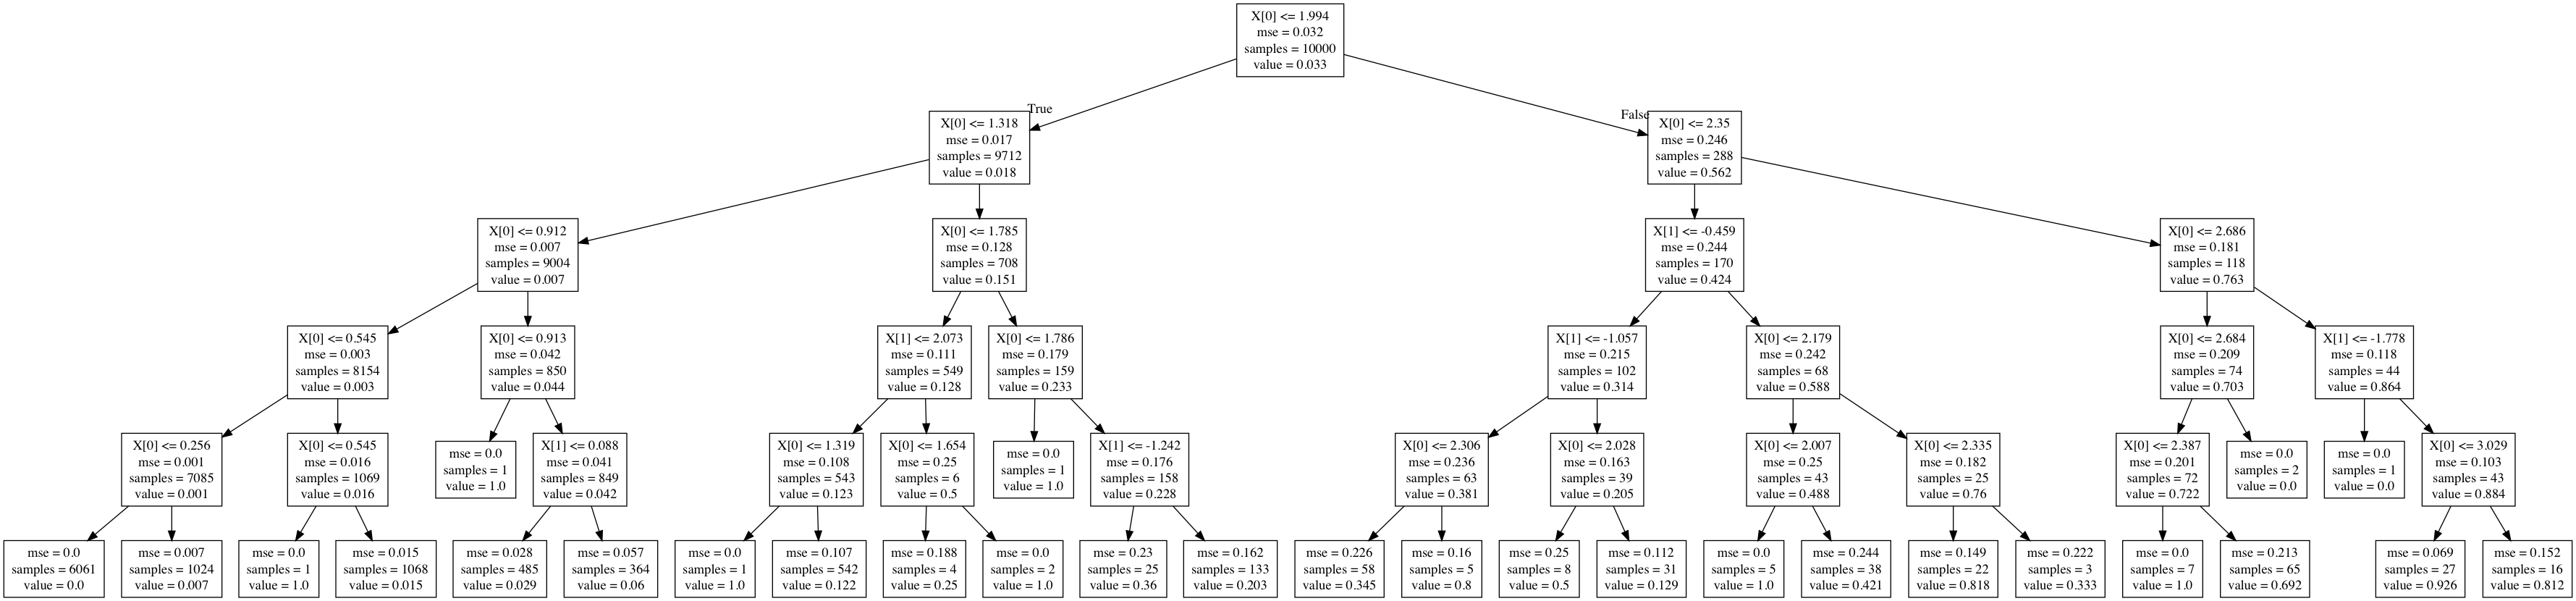

In [147]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
import pydotplus
from IPython.display import Image

X=df[['balance','income']]
y=df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
tr_regr = DecisionTreeRegressor(max_depth=5)
tr_regr.fit(X, y)

def visualize_tree(tree, feature_names):
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
from __future__ import print_function

dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(tr_regr, feature_names=['x'])

dot_data=export_graphviz(tr_regr, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

8) Find the optimal decision tree depth and compute the AUC ROC. 

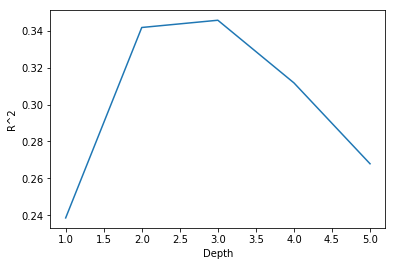

depth: 5
Area under the ROC curve : 0.930455


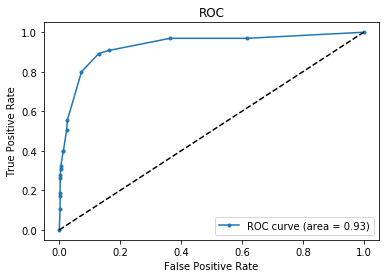

depth: 4
Area under the ROC curve : 0.954498


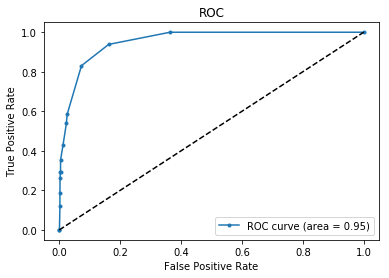

depth: 3
Area under the ROC curve : 0.935659


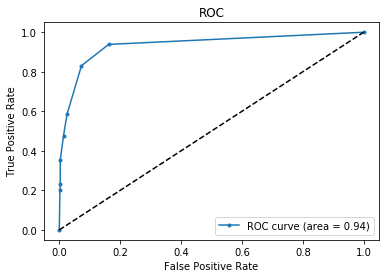

depth: 2
Area under the ROC curve : 0.892292


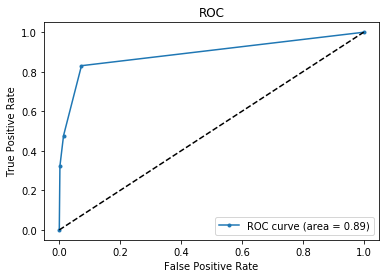

depth: 1
Area under the ROC curve : 0.731485


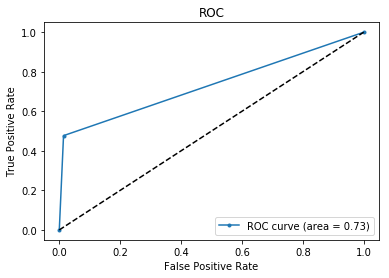

AUC is the largest when depth= 4


In [148]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]
plt.show()

all_area=[]
print("depth:",n_opt+2)
fpr,tpr,roc_auc1, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt+2)
generate_ROCplot(fpr,tpr,'LR',roc_auc1)
all_area.append(roc_auc1)

print("depth:",n_opt+1)
fpr,tpr,roc_auc2, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt+1)
generate_ROCplot(fpr,tpr,'LR',roc_auc2)
all_area.append(roc_auc2)

print("depth:",n_opt)
fpr,tpr,roc_auc3, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt)
generate_ROCplot(fpr,tpr,'LR',roc_auc3)
all_area.append(roc_auc3)

print("depth:",n_opt-1)
fpr,tpr,roc_auc4, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt-1)
generate_ROCplot(fpr,tpr,'LR',roc_auc4)
all_area.append(roc_auc4)

print("depth:",n_opt-2)
fpr,tpr,roc_auc5, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = n_opt-2)
generate_ROCplot(fpr,tpr,'LR',roc_auc5)
all_area.append(roc_auc5)

max_area=max(all_area)
if max_area==roc_auc1:
    opt_depth=n_opt+2
elif max_area==roc_auc2:
    opt_depth=n_opt+1
elif max_area==roc_auc3:
    opt_depth=n_opt
elif max_area==roc_auc4:
    opt_depth=n_opt-1
elif max_area==roc_auc5:
    opt_depth=n_opt-2
print("AUC is the largest when depth=",opt_depth)

**R2 is the largest when depth=3. However, when we see examine the AUCs, it turns out that depth=4 would have the largest AUC. We could conclude that 4 is the optimal depth.**